In [1]:
import yaml
import glob

import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader
import pytorch_lightning
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from models.ghostnet import GhostNet
from models.convolutional import CNN1D
import utils.dataset
from utils.dataset import ESC50, UrbanSound8K, AudioSet

from pytorch_grad_cam import XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import librosa
import torchaudio


In [2]:
def load_dataloader(path, config, fold):
    transforms = None
    if config['model']['type'] == 'ghostnet':
        transforms = [torchaudio.transforms.MelSpectrogram(sample_rate=config['target_sr'],
                                                                f_min=0,
                                                                n_fft=config['transforms']['mel_spectrogram']['n_fft'],
                                                                win_length=config['transforms']['mel_spectrogram']['n_fft'],
                                                                hop_length=config['transforms']['mel_spectrogram']['hop_length'],
                                                                center=config['transforms']['mel_spectrogram']['center'],
                                                                normalized=config['transforms']['mel_spectrogram']['normalized'],
                                                                mel_scale="slaney",
                                                                n_mels=config['transforms']['mel_spectrogram']['n_mels'],
                                                                power=config['transforms']['mel_spectrogram']['power']),
                            torchaudio.transforms.AmplitudeToDB(top_db=80.0)]
    if config['datasets']['main'] == 'esc50':
        dataset = ESC50(train=False,
                annotations_file=config['datasets']['esc50']['annotations_file'],
                audio_dir=config['datasets']['esc50']['audio_dir'],
                folds=[fold],
                transforms=transforms,
                target_sr=config['target_sr'],
                target_size=config['target_size'],
                model=config['model']['type'],
                mixup=False)
    elif config['datasets']['main'] == 'urbansound8k':
        dataset = UrbanSound8K(train=False,
                annotations_file=config['datasets']['urbansound8k']['annotations_file'],
                audio_dir=config['datasets']['urbansound8k']['audio_dir'],
                folds=[fold],
                transforms=transforms,
                target_sr=config['target_sr'],
                target_size=config['target_size'],
                model=config['model']['type'],
                mixup=False)

    return DataLoader(dataset=dataset, drop_last=True, num_workers=config['workers'], collate_fn=utils.dataset.collate_fn, persistent_workers=True)

# Latent Space

In [6]:
class LatentSpaceCNN1D(CNN1D):
    def __init__(self, learning_rate=1e-3, log_path='./', patience=20):
        super().__init__(learning_rate, log_path, patience)

    def forward(self, x):
        x = self.conv1d(x)
        x = self.linear[:-1](x)
        return torch.flatten(x, 1)

class LatentSpaceGhostNet(GhostNet):
    def __init__(self, cfgs,  learning_rate, log_path, patience, num_classes=2, width=1.0, dropout=0.2):
        super().__init__(cfgs,  learning_rate, log_path, patience, num_classes, width, dropout)
    
    def forward(self, x):
        x = self.conv_stem(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.blocks(x)
        x = self.global_pool(x)
        x = self.conv_head(x)
        x = self.act2(x)
        x = x.reshape(-1, 512)
        if self.dropout > 0.:
            x = F.dropout(x, p=self.dropout, training=self.training)
        return torch.flatten(x, 1)

In [7]:
def load_model(path, config, fold):
    model_path = glob.glob(f"{path}/{config['datasets']['main']}-{fold}/trained_models/*.ckpt")[0]
    if config['model']['type'] == 'cnn1d':
        return LatentSpaceCNN1D.load_from_checkpoint(checkpoint_path=model_path,
                                                        learning_rate=config['learning_rate'],
                                                        log_path=path,
                                                        patience=int(config['epochs'] / 10))
    elif config['model']['type'] == 'ghostnet':
        return LatentSpaceGhostNet.load_from_checkpoint(checkpoint_path=model_path,
                                                                cfgs=config['model']['ghostnet']['stages'],
                                                                width=config['model']['ghostnet']['width'],
                                                                learning_rate=config['learning_rate'],
                                                                log_path=path,
                                                                patience=int(config['epochs'] / 10))

In [8]:
def get_features(model, dataloader):
    model.eval()
    features = None
    labels = None

    for batch in tqdm(dataloader, desc='Running the model inference'):
        signal = batch[0].to('cpu')
        label = np.vstack([batch[1]]*len(signal))

        with torch.no_grad():
            output = model(signal)
        current_features= output.cpu().numpy()
        if features is not None:
            features = np.concatenate((features, current_features))
        else:
            features = current_features
        if labels is not None:
            labels = np.concatenate((labels, label))
        else:
            labels = label

    return features, labels.argmax(1)

In [9]:
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))
    starts_from_zero = x - np.min(x)
    return starts_from_zero / value_range

def plot_tsne(features, labels, perplexity, learning_rate, title):
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity, learning_rate=learning_rate, n_iter=5000).fit_transform(features)
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    tz = tsne[:, 2]
    tx = scale_to_01_range(tx)
    ty = scale_to_01_range(ty)
    tz = scale_to_01_range(tz)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')

    for label in [0, 1]:
        indices = [i for i, l in enumerate(labels) if l == label]
        current_tx = np.take(tx, indices)
        current_ty = np.take(ty, indices)
        current_tz = np.take(tz, indices)
        ax.scatter(current_tx, current_ty, current_tz, label=label)
    ax.set_title(title)
    ax.legend(loc='best')
    plt.show()

In [11]:
def plot_multiple_tsne(path, dataset_name, config, title):
    all_features = None
    all_labels = None

    for f in config['datasets'][dataset_name]['folds']:
        pl_model_esc = load_model(path, config, f)
        dataloader_esc = load_dataloader(path, config, f)
        features, labels = get_features(pl_model_esc, dataloader_esc)    
        if all_features is None:
            all_features = features
            all_labels = labels
        else:
            all_features = np.concatenate((all_features, features))
            all_labels = np.concatenate((all_labels, labels))

    plot_tsne(all_features, all_labels, perplexity=100, learning_rate=100, title=title)

Running the model inference: 100%|██████████| 400/400 [00:09<00:00, 42.12it/s]


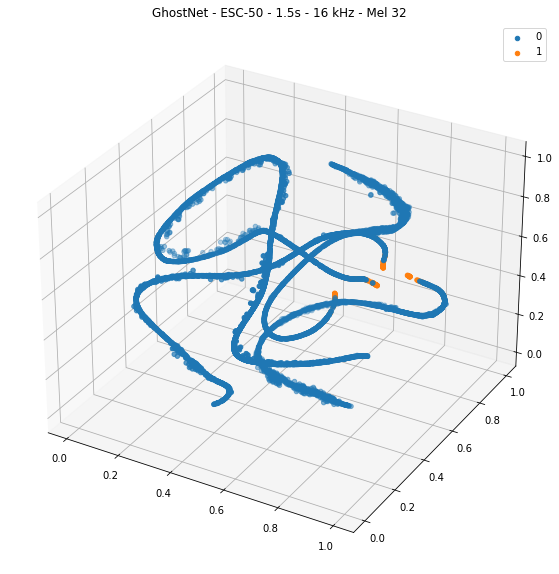

In [10]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_tsne(path, 'esc50', config, "GhostNet - ESC-50 - 1.5s - 16 kHz - Mel 32")

Running the model inference: 100%|██████████| 936/936 [00:28<00:00, 32.69it/s]


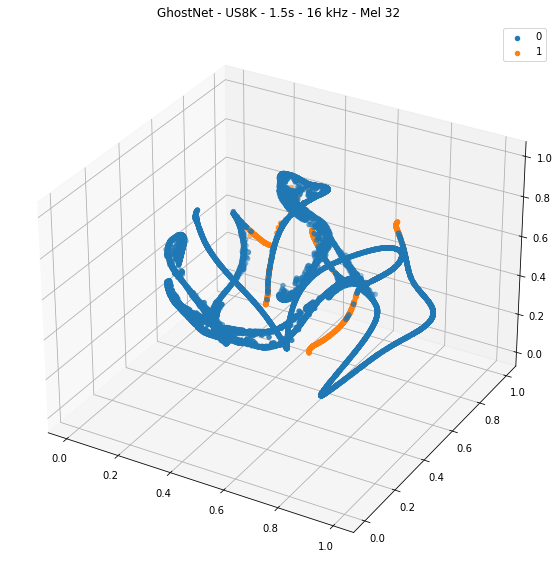

In [12]:
path = "./trained_models/us8k/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_tsne(path, 'esc50', config, "GhostNet - US8K - 1.5s - 16 kHz - Mel 32")


Running the model inference: 100%|██████████| 400/400 [00:11<00:00, 36.00it/s]


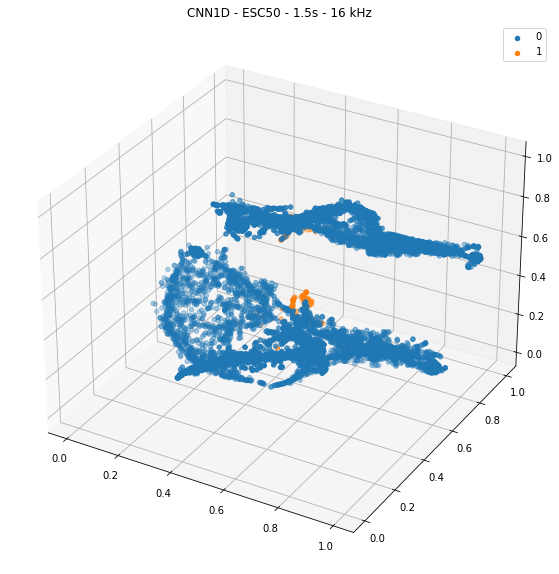

In [13]:
path = "./trained_models/esc50/16000-15-conv1d"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_tsne(path, 'esc50', config,  title="CNN1D - ESC50 - 1.5s - 16 kHz")

Running the model inference: 100%|██████████| 936/936 [00:19<00:00, 48.19it/s] 


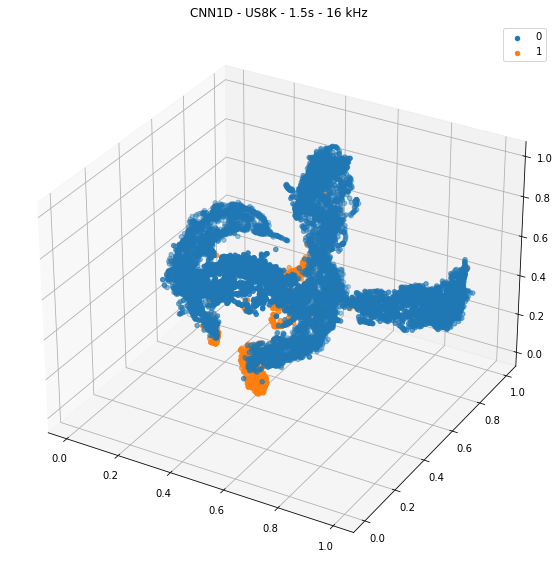

In [14]:
path = "./trained_models/us8k/16000-15-conv1d"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_tsne(path, 'esc50', config, title="CNN1D - US8K - 1.5s - 16 kHz")

# Grad-CAM

In [3]:
def load_cam_model(path, config, fold, layers_from_end):
    model_path = glob.glob(f"{path}/{config['datasets']['main']}-{fold}/trained_models/*.ckpt")[0]
    if config['model']['type'] == 'ghostnet':
        model = GhostNet.load_from_checkpoint(checkpoint_path=model_path,
                                              cfgs=config['model']['ghostnet']['stages'],
                                              width=config['model']['ghostnet']['width'],
                                              learning_rate=config['learning_rate'],
                                              log_path=path,
                                              patience=int(config['epochs'] / 10))
        return XGradCAM(model=model, target_layers=[model.blocks[layers_from_end]])

In [4]:
def plot_heatmap(heatmap, mel_to_freq, n_mels, sr):
    plt.figure(figsize=(20, 10))
    ax = plt.axes()
    plt.imshow(heatmap, origin='lower')

    if mel_to_freq:
        ax.set_yticks([*range(0, heatmap.shape[0], 3)])
        ax.set_yticklabels(librosa.mel_frequencies(n_mels, fmax=sr/2)[::3].astype(int))


In [5]:
def plot_signal_and_heatmap(signal, label, model, n_mels, sr):
    label = torch.argmax(label).item()
    print(f'Label: {label}')
    res = None
    for i in range(signal.shape[0]):
        signal_ = signal[i].unsqueeze(0)
        grayscale_cam = model(input_tensor=signal_, targets=[ClassifierOutputTarget(label)])
        grayscale_cam = grayscale_cam[0, :]
        signal_gray = ((signal_ - signal_.min())/(signal_.max()- signal_.min())).reshape(signal_.shape[2],signal_.shape[3])
        signal_rgb = cv2.cvtColor(signal_gray.numpy(), cv2.COLOR_GRAY2RGB)
        visualization = show_cam_on_image(signal_rgb, grayscale_cam, use_rgb=True)
        if res is None:
            res = visualization
        else:
            res = np.hstack([res, visualization])
    
    plot_heatmap(res, mel_to_freq=True, n_mels=n_mels, sr=sr)


### Exploratory

#### Siren

In [165]:
path = "./trained_models/esc50/16000-15-mel32"
fold = 1
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

Label: 1


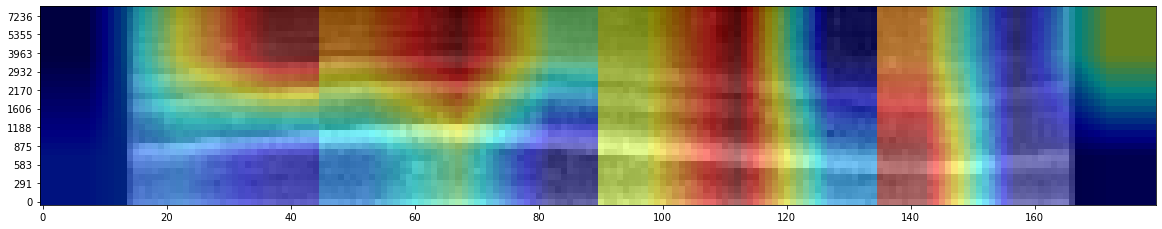

In [167]:
signal, label = next(iterator)
plot_signal_and_heatmap(signal, label, cam_model, 32, 16000)

#### Car Horn

In [177]:
path = "./trained_models/esc50/16000-15-mel32"
fold = 1
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

Label: 0


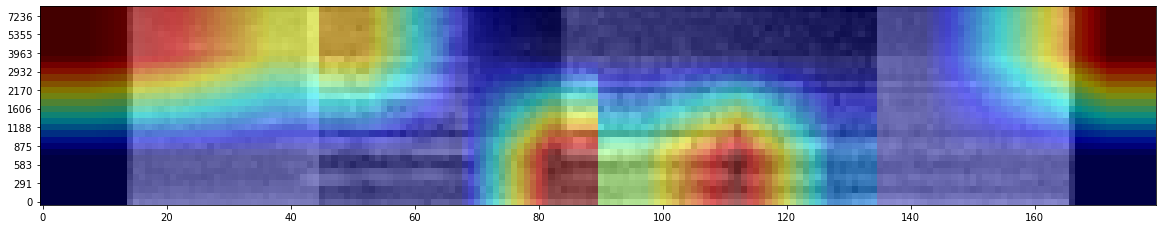

In [181]:
signal, label = next(iterator)
plot_signal_and_heatmap(signal, label, cam_model, 32, 16000)

#### Engine

In [186]:
path = "./trained_models/esc50/16000-15-mel32"
fold = 1
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

Label: 0


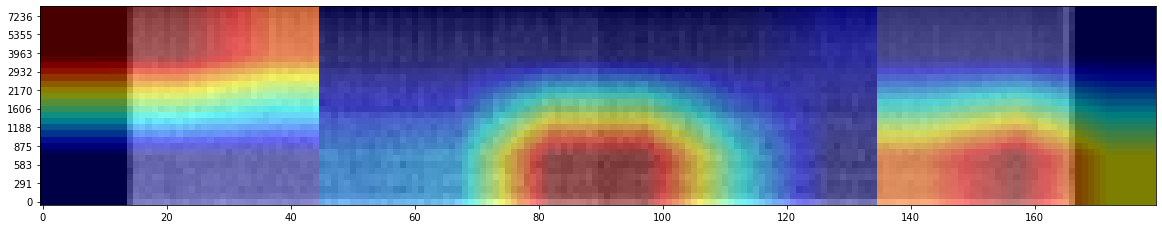

In [187]:
signal, label = next(iterator)
plot_signal_and_heatmap(signal, label, cam_model, 32, 16000)

#### Wind

In [189]:
path = "./trained_models/esc50/16000-15-mel32"
fold = 1
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

cam_model = load_cam_model(path, config, fold, layers_from_end=-4)
dataloader_esc = load_dataloader(path, config, fold)    
iterator = iter(dataloader_esc)

Label: 0


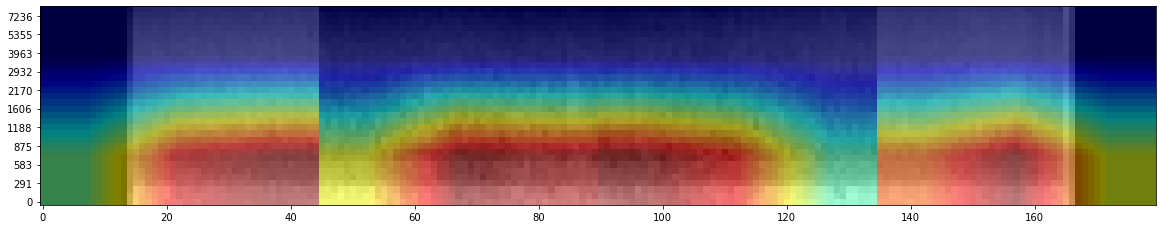

In [190]:
signal, label = next(iterator)
plot_signal_and_heatmap(signal, label, cam_model, 32, 16000)

### Multiple Heatmaps

In [150]:
def gram_cam_heatmap(model, dataloader):
    negative = None
    positive = None
    for signal, label in tqdm(dataloader, desc='Running the model inference'):
        res = None
        if torch.argmax(label).item():
            for i in range(signal.shape[0]):
                signal_ = signal[i].unsqueeze(0)
                grayscale_cam = model(input_tensor=signal_, targets=[ClassifierOutputTarget(1)])
                grayscale_cam = grayscale_cam[0, :]
                if res is None:
                    res = grayscale_cam
                else:
                    res = np.hstack([res, grayscale_cam])
            if positive is None:
                positive = res
            else:
                positive += res
        else:
            for i in range(signal.shape[0]):
                signal_ = signal[i].unsqueeze(0)
                grayscale_cam = model(input_tensor=signal_, targets=[ClassifierOutputTarget(0)])
                grayscale_cam = grayscale_cam[0, :]
                if res is None:
                    res = grayscale_cam
                else:
                    res = np.hstack([res, grayscale_cam])
            if negative is None:
                negative = res
            else:
                negative += res
    return positive, negative

In [173]:
def plot_multiple_grad_cam(path, dataset_name, config):
    
    sum_pos_heatmap = None
    sum_neg_heatmap = None

    for f in config['datasets'][dataset_name]['folds']:
        cam_model = load_cam_model(path, config, fold=f, layers_from_end=-4)
        dataloader_esc = load_dataloader(path, config, fold=f)    
        pos_heatmap, neg_heatmap = gram_cam_heatmap(cam_model, dataloader_esc)
        if sum_pos_heatmap is None:
            sum_pos_heatmap = pos_heatmap
        else:
            sum_pos_heatmap += pos_heatmap

        if sum_neg_heatmap is None:
            sum_neg_heatmap = neg_heatmap
        else:
            sum_neg_heatmap += neg_heatmap

    if sum_pos_heatmap is not None:
        plot_heatmap(sum_pos_heatmap, mel_to_freq=True, n_mels=config['transforms']['mel_spectrogram']['n_mels'], sr=config['target_sr'])
        plt.title('Positive')
    if sum_neg_heatmap is not None:
        plot_heatmap(sum_neg_heatmap, mel_to_freq=True, n_mels=config['transforms']['mel_spectrogram']['n_mels'], sr=config['target_sr'])
        plt.title('Negative')
    

### Positive and negative

#### 16000 Hz 1.5s Mel 32

Running the model inference: 100%|██████████| 400/400 [00:45<00:00,  8.76it/s]


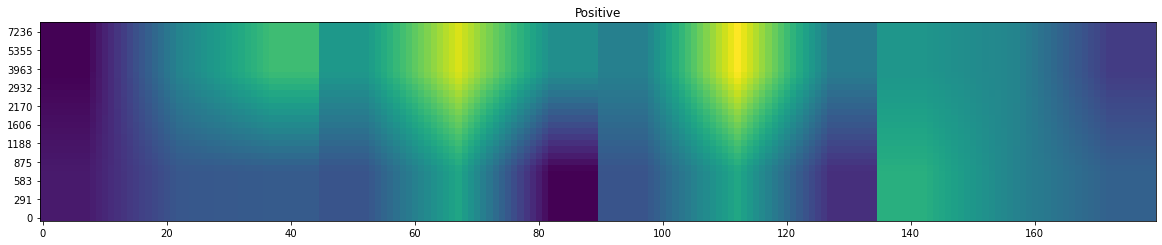

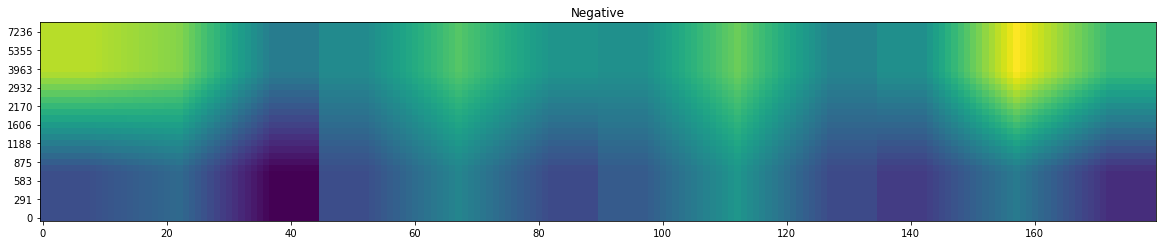

In [156]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

#### 16000 Hz 1.5s Mel 64

Running the model inference: 100%|██████████| 400/400 [00:47<00:00,  8.36it/s]


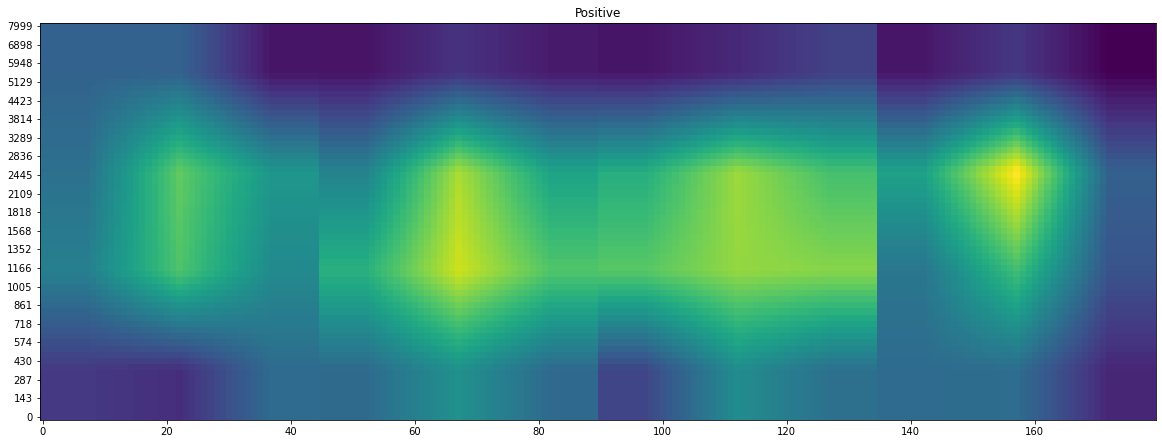

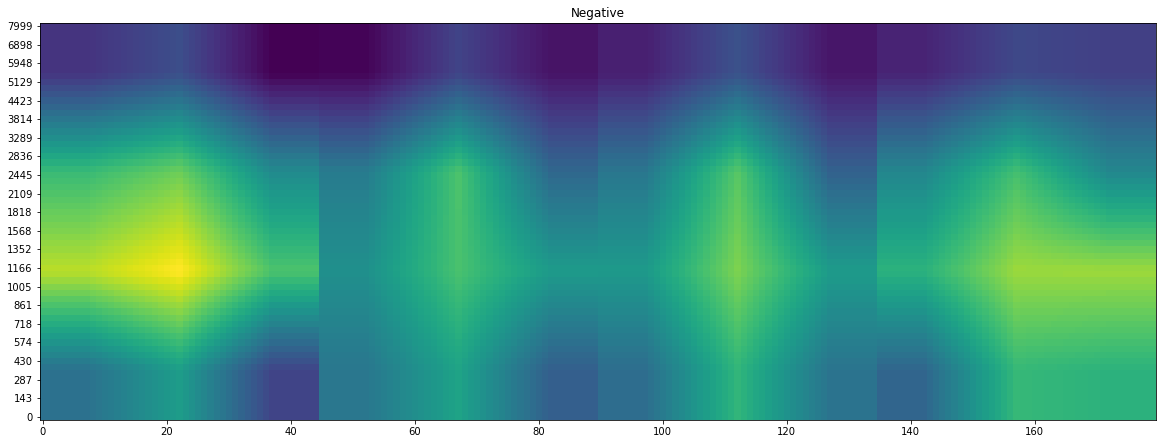

In [153]:
path = "./trained_models/esc50/16000-15-mel64"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

#### 16000 Hz 1s Mel 32

Running the model inference: 100%|██████████| 400/400 [00:59<00:00,  6.70it/s]


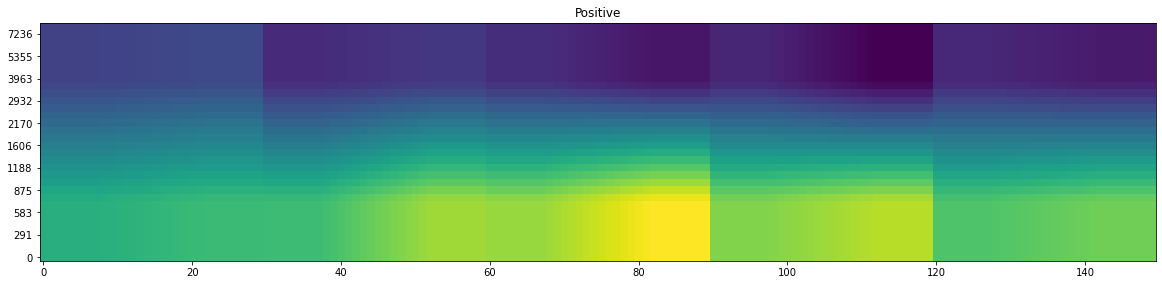

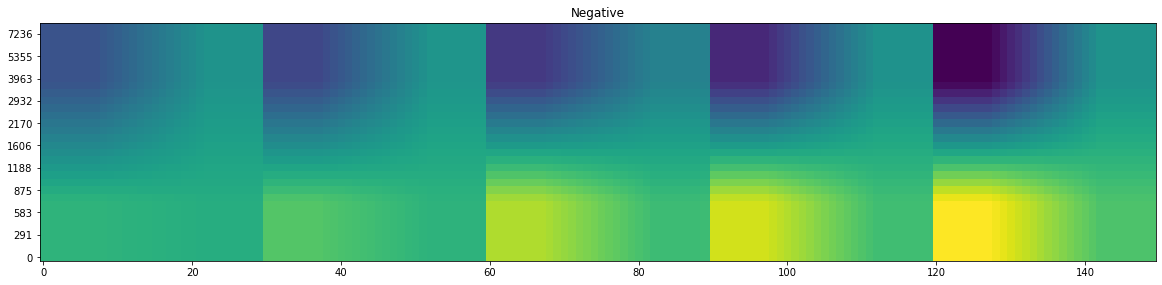

In [157]:
path = "./trained_models/esc50/16000-1-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

#### 16000 Hz 1s Mel 64

Running the model inference: 100%|██████████| 400/400 [00:57<00:00,  6.94it/s]


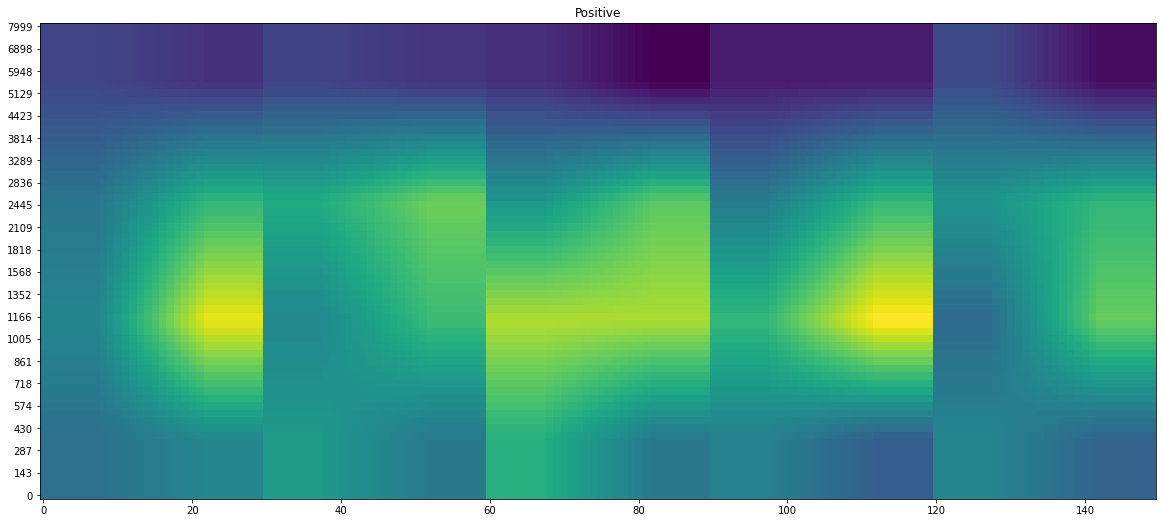

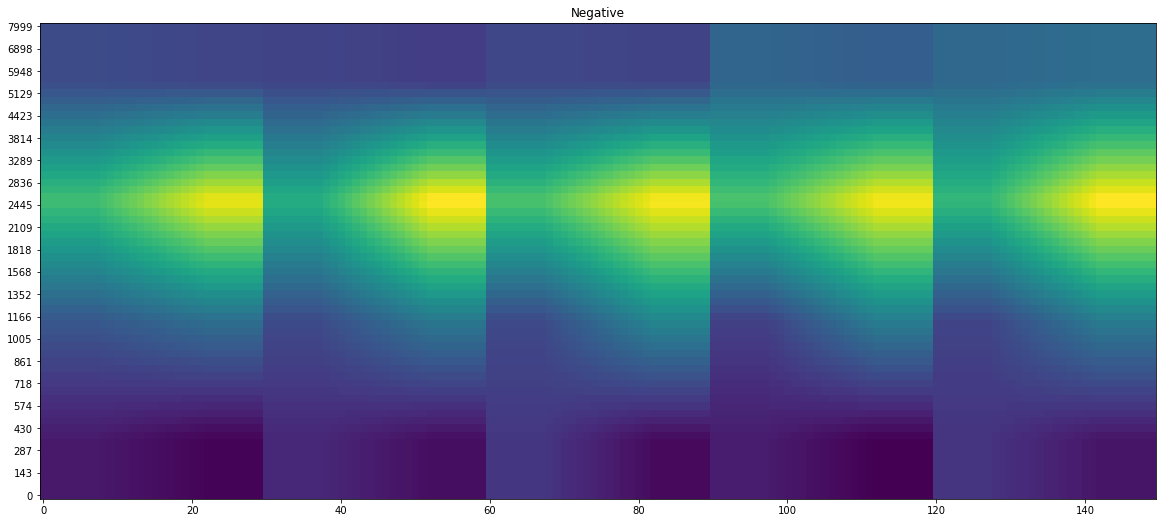

In [158]:
path = "./trained_models/esc50/16000-1-mel64"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

### 16000 Hz 1.5s Mel 32

#### Siren

Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.32it/s]


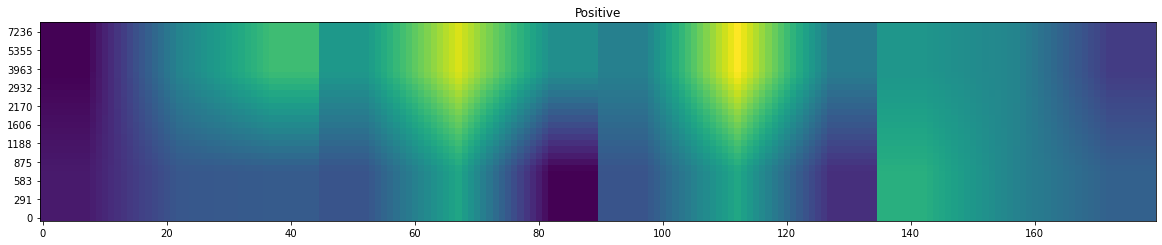

In [174]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

 ### Car Horn

Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


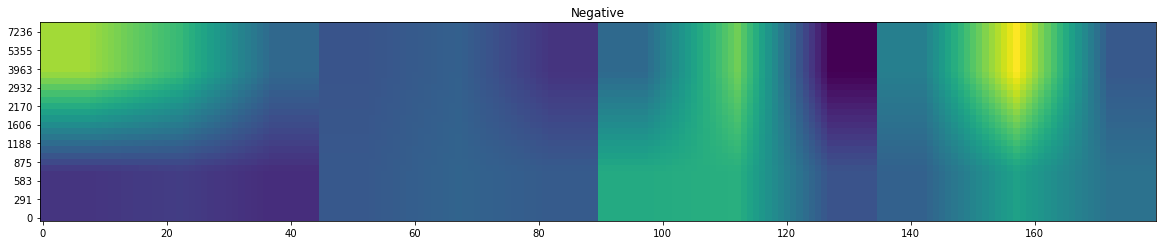

In [182]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

### Engine

Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


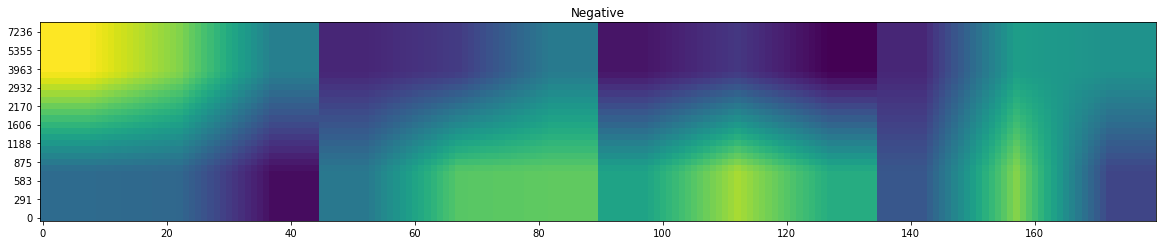

In [188]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)

### Wind

Running the model inference: 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


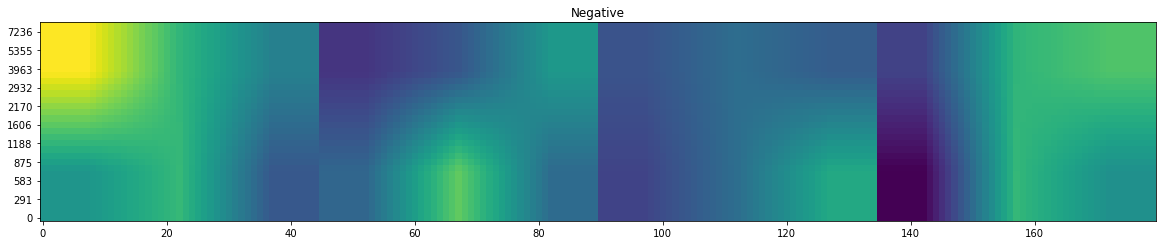

In [191]:
path = "./trained_models/esc50/16000-15-mel32"
with open(f"{path}/config.yaml", errors='ignore') as f:
    config = yaml.safe_load(f)

plot_multiple_grad_cam(path, 'esc50', config)